In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import logging
logging.basicConfig(level=logging.INFO, format=' %(asctime)s - %(levelname)s - %(message)s')

import levy_stable_jax as lsj
import jax.numpy as jnp
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import levy_stable as sp_levy_stable
import jax

sp_levy_stable.parameterization = "S0"


In [106]:
# (alpha, beta) = (1.5944529757446195, 0.9140602576756717)
(alpha, beta) = (1.9999989999999999, 0.9999890000100001)
# (alpha, beta) = (1.2, -0.9999) #9999890000100001)
alpha = 1.9193154521329552
beta = 0.8991364476436018
loc, scale = 0.0, 1.0

<Axes: >

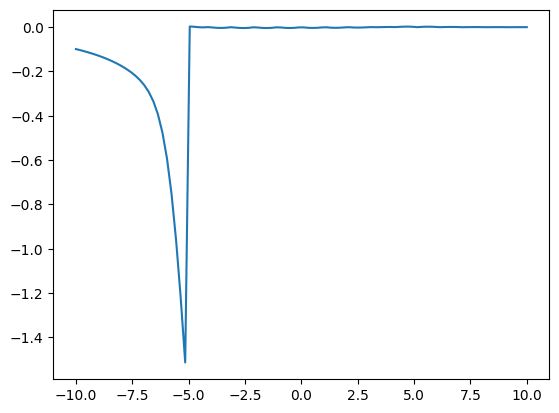

In [107]:
xs = jnp.linspace(-10, 10, 100)
sns.lineplot(x=xs,
             y=lsj.logpdf(xs, alpha,beta,loc, scale, "N0")-sp_levy_stable.logpdf(xs,alpha=alpha, beta=beta))
# sns.lineplot(x=xs,
#              y=sp_levy_stable.logpdf(xs,alpha=alpha, beta=beta))

<Axes: >

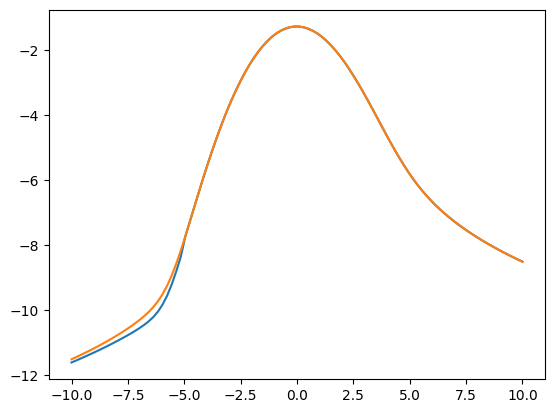

In [112]:
xs = jnp.linspace(-10, 10, 100)
sns.lineplot(x=xs,
             y=lsj.logpdf(xs, alpha,beta))
sns.lineplot(x=xs,
             y=sp_levy_stable.logpdf(xs,alpha=alpha, beta=beta))

In [109]:
lpdf = levy_stable_jax._cache.jax_read_from_cache("logpdf")
lpdf.shape

NameError: name 'levy_stable_jax' is not defined

In [ ]:
locs = jnp.asarray([1.0, 2.0])
scales = jnp.asarray(1.0)
A = jnp.asarray([[1,2],[3,4],[5,6]])
b = jnp.asarray([[2,2,2]]).T

A * locs + b

In [ ]:
locs = jnp.asarray([1.0, 1.1])
scales = 2.0
A = jnp.asarray([[1,2],[3,4],[5,6]])
b = jnp.asarray([[2,2,2]]).T
(beta1, loc1, scale1) = lsj.shift_scale(2.0, 0.0,locs, scales, A,b,"N1")
(beta1, loc1, scale1)

In [ ]:
lsj.sum(2.0, beta1, loc1, scale1, param="N1", axis=0)

In [ ]:
raise

In [ ]:
from levy_stable_jax.distribution import TAB_X_CUTOFF, NUM_X_POINTS, ALPHA_MIN, ALPHA_MAX, NUM_ALPHA_POINTS, BETA_MIN, BETA_MAX, NUM_BETA_POINTS
xs = np.linspace(-TAB_X_CUTOFF, TAB_X_CUTOFF, NUM_X_POINTS)
alphas = np.linspace(ALPHA_MIN, ALPHA_MAX, NUM_ALPHA_POINTS)
betas = np.linspace(BETA_MIN, BETA_MAX, NUM_BETA_POINTS)
dx = 2 * TAB_X_CUTOFF / NUM_X_POINTS
NUM_BETA_POINTS

In [ ]:
alpha_idx = 40
beta_idx = 43
ys = np.array(lpdf[:,alpha_idx,beta_idx])
alpha = alphas[alpha_idx]
beta = betas[beta_idx]
print("alpha",alpha,"beta",beta)
with levy_stable_jax._utils.set_stable("N0"):
    ys0 = sp_levy_stable.logpdf(xs, alpha=alpha, beta=beta)
sns.lineplot(x=xs, y=ys0)
sns.lineplot(x=xs, y=ys)


In [ ]:
beta

In [ ]:
sns.scatterplot(x=xs, y=np.gradient(lpdf[:,alpha_idx,beta_idx]))

In [ ]:
sns.scatterplot(x=xs, y=ys)

# Check random parameters

In [101]:
prng = jax.random.PRNGKey(1)
ys = lsj.rvs(alpha=1.8, beta=-1.0,loc=10.0, scale=0.5,param="N1",prng=prng,shape=(1000,))

<Axes: ylabel='Count'>

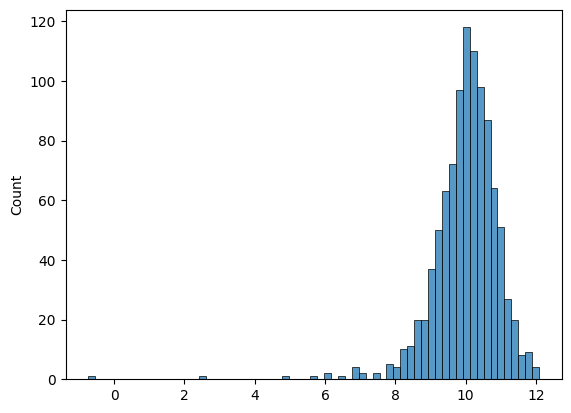

In [102]:
sns.histplot(ys)

In [103]:
import levy_stable_jax.estimation

In [104]:
lsj.estimation.fit_ll(ys, alpha=1.8, beta=None, param="N1")

Array([ 1.8      , -0.9979979,  9.987296 ,  0.5174795], dtype=float32)